<a href="https://colab.research.google.com/github/hewansirak/Do-Vision-Models-Use-Their-Depth-Efficiently/blob/main/exp-h1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
Vision Transformer Attention Pattern Analysis
Experiment: Visualize attention patterns across layers to understand
where different layers "look" in the image
"""

from transformers import AutoImageProcessor
from modeling_vit import ViTForImageClassification
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
processor = AutoImageProcessor.from_pretrained("facebook/deit-small-patch16-224")
model = ViTForImageClassification.from_pretrained("facebook/deit-small-patch16-224")
model = model.eval()

# Load dataset
ds = load_dataset("pouya-haghi/imagenet-1k", split="train")

print(f"Model loaded: {model.config.num_hidden_layers} layers")
print(f"Number of attention heads per layer: {model.config.num_attention_heads}")
print(f"Image size: {model.config.image_size}")
print(f"Patch size: {model.config.patch_size}")
print(f"Number of patches: {(model.config.image_size // model.config.patch_size) ** 2}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


pytorch_model.bin:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/314 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/43.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1024 [00:00<?, ? examples/s]

Model loaded: 12 layers
Number of attention heads per layer: 6
Image size: 224
Patch size: 16
Number of patches: 196


In [4]:
# Cell 2.5: Force Model to Return Attention Weights (INSERT AFTER CELL 2)
# We need to modify the model configuration to ensure attention weights are returned

# Check current attention implementation
print(f"Current attention implementation: {model.config._attn_implementation}")

# Force eager attention (which returns attention weights)
model.config._attn_implementation = "eager"

# Verify
print(f"Updated attention implementation: {model.config._attn_implementation}")
print("\nModel configured to return attention weights!")

Current attention implementation: sdpa
Updated attention implementation: eager

Model configured to return attention weights!


In [5]:
# Cell 3: Debug Version - REPLACE ENTIRELY
def get_attention_weights(model, pixel_values):
    """
    Forward pass that captures attention weights from all layers.
    """
    attention_weights = []

    # Hook to capture what's actually returned
    def hook_fn(module, input, output):
        print(f"Hook triggered on {module.__class__.__name__}")
        print(f"Output type: {type(output)}")

        if isinstance(output, tuple):
            print(f"Tuple length: {len(output)}")
            for i, item in enumerate(output):
                if isinstance(item, torch.Tensor):
                    print(f"  Item {i}: Tensor with shape {item.shape}")
                else:
                    print(f"  Item {i}: {type(item)} = {item}")

            # Try to capture attention
            if len(output) >= 2 and output[1] is not None:
                attention_weights.append(output[1].detach())
        else:
            if isinstance(output, torch.Tensor):
                print(f"Single tensor output with shape: {output.shape}")

        print("-" * 50)

    # Register hooks on ViTSelfAttention
    hooks = []
    for i, layer in enumerate(model.vit.encoder.layer):
        print(f"Registering hook on layer {i}: {layer.attention.attention.__class__.__name__}")
        hook = layer.attention.attention.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass
    print("\nStarting forward pass...")
    with torch.no_grad():
        outputs = model(pixel_values)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    print(f"\nCaptured {len(attention_weights)} attention weight tensors")
    if len(attention_weights) > 0:
        print(f"Each attention tensor shape: {attention_weights[0].shape}")

    return attention_weights, outputs

print("Debug function defined! Ready to test.")

Debug function defined! Ready to test.


Registering hook on layer 0: ViTSelfAttention
Registering hook on layer 1: ViTSelfAttention
Registering hook on layer 2: ViTSelfAttention
Registering hook on layer 3: ViTSelfAttention
Registering hook on layer 4: ViTSelfAttention
Registering hook on layer 5: ViTSelfAttention
Registering hook on layer 6: ViTSelfAttention
Registering hook on layer 7: ViTSelfAttention
Registering hook on layer 8: ViTSelfAttention
Registering hook on layer 9: ViTSelfAttention
Registering hook on layer 10: ViTSelfAttention
Registering hook on layer 11: ViTSelfAttention

Starting forward pass...
Hook triggered on ViTSelfAttention
Output type: <class 'tuple'>
Tuple length: 2
  Item 0: Tensor with shape torch.Size([1, 197, 384])
  Item 1: Tensor with shape torch.Size([1, 6, 197, 197])
--------------------------------------------------
Hook triggered on ViTSelfAttention
Output type: <class 'tuple'>
Tuple length: 2
  Item 0: Tensor with shape torch.Size([1, 197, 384])
  Item 1: Tensor with shape torch.Size([1, 6

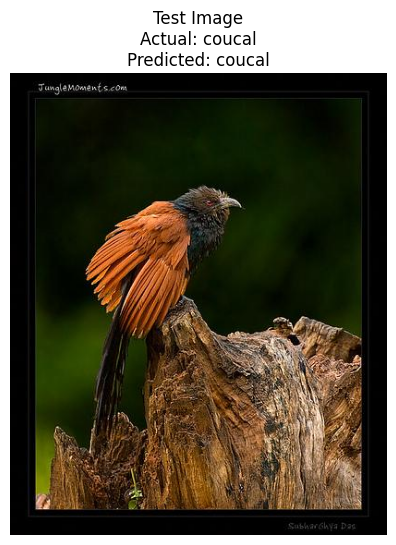

In [6]:
test_idx = 0
image = ds[test_idx]['image']
if image.mode != 'RGB':
    image = image.convert('RGB')

inputs = processor(images=image, return_tensors="pt")
attention_weights, outputs = get_attention_weights(model, inputs.pixel_values)

# Get prediction
predicted_class_idx = outputs.logits.argmax(-1).item()
actual_label = ds[test_idx]['label']

print(f"Image shape: {inputs.pixel_values.shape}")
print(f"Number of layers with attention: {len(attention_weights)}")
print(f"Attention shape per layer: {attention_weights[0].shape}")
print(f"(batch_size, num_heads, num_patches+1, num_patches+1)")
print(f"\nPredicted: {model.config.id2label[predicted_class_idx]}")
print(f"Actual: {model.config.id2label[actual_label]}")

# Display image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f"Test Image\nActual: {model.config.id2label[actual_label]}\nPredicted: {model.config.id2label[predicted_class_idx]}")
plt.show()

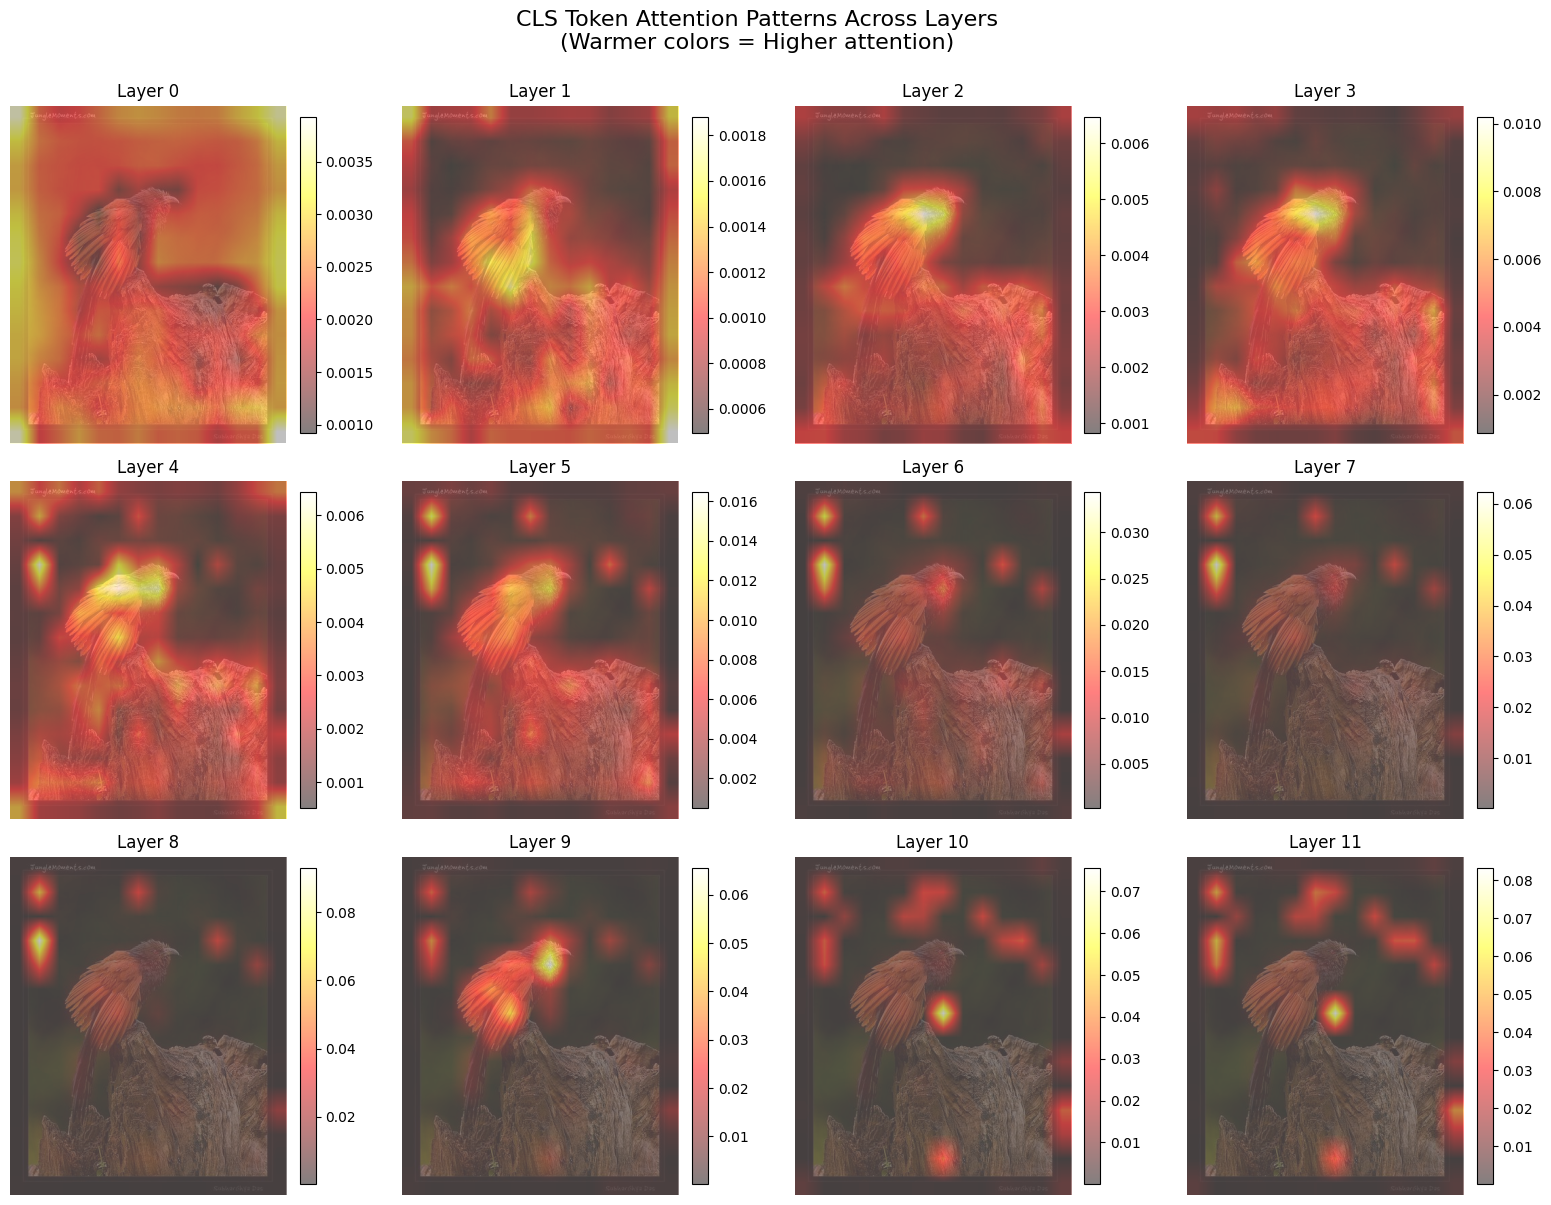

In [7]:
def visualize_cls_attention_grid(attention_weights, image, num_cols=4):
    """
    Visualize attention from CLS token to all patches across all layers.
    """
    num_layers = len(attention_weights)
    num_rows = (num_layers + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    axes = axes.flatten() if num_layers > 1 else [axes]

    patch_size = model.config.patch_size
    num_patches = model.config.image_size // patch_size

    for layer_idx, attn in enumerate(attention_weights):
        # Average across all heads
        attn_avg = attn[0].mean(dim=0)  # (num_patches+1, num_patches+1)

        # Get CLS token attention to all patches (excluding CLS itself)
        cls_attn = attn_avg[0, 1:]  # (num_patches*num_patches,)

        # Reshape to 2D grid
        cls_attn_2d = cls_attn.reshape(num_patches, num_patches).cpu().numpy()

        # Visualize
        ax = axes[layer_idx]
        ax.imshow(image, alpha=0.5)
        im = ax.imshow(cls_attn_2d, cmap='hot', alpha=0.5,
                      extent=[0, image.size[0], image.size[1], 0],
                      interpolation='bilinear')
        ax.set_title(f'Layer {layer_idx}', fontsize=12)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide extra subplots
    for idx in range(num_layers, len(axes)):
        axes[idx].axis('off')

    plt.suptitle('CLS Token Attention Patterns Across Layers\n(Warmer colors = Higher attention)',
                 fontsize=16, y=1.00)
    plt.tight_layout()
    return fig

fig = visualize_cls_attention_grid(attention_weights, image)
plt.show()


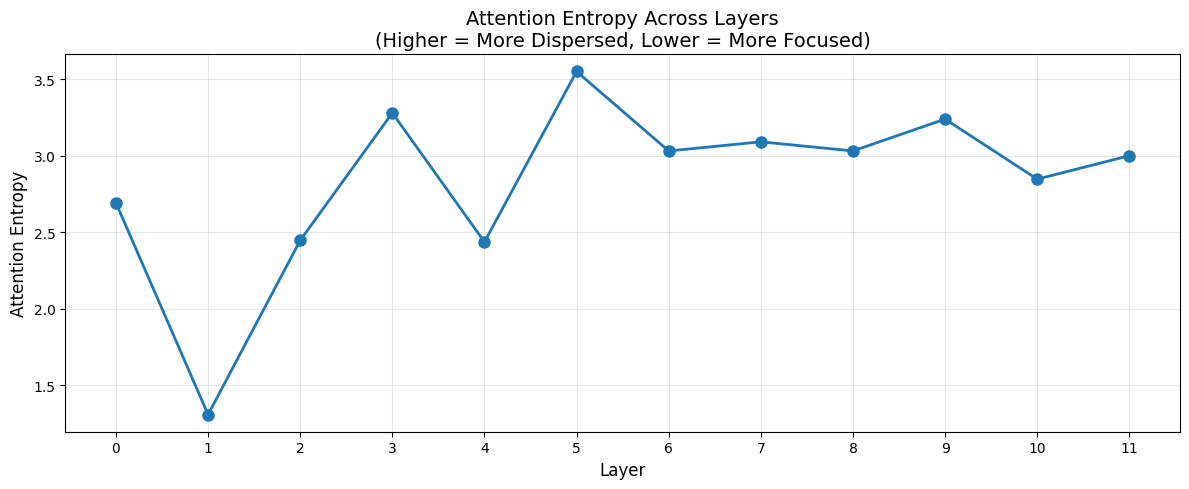


Attention Entropy by Layer:
Layer 0: 2.6911
Layer 1: 1.3074
Layer 2: 2.4458
Layer 3: 3.2793
Layer 4: 2.4357
Layer 5: 3.5501
Layer 6: 3.0305
Layer 7: 3.0903
Layer 8: 3.0307
Layer 9: 3.2389
Layer 10: 2.8464
Layer 11: 2.9995


In [8]:
def compute_attention_entropy(attention_weights):
    """
    Compute entropy of attention patterns to measure how focused/dispersed they are.
    Higher entropy = more dispersed attention
    Lower entropy = more focused attention
    """
    entropies = []

    for layer_idx, attn in enumerate(attention_weights):
        # Average across batch and heads
        attn_avg = attn[0].mean(dim=0)  # (num_patches+1, num_patches+1)

        # Get CLS token attention
        cls_attn = attn_avg[0, 1:]  # exclude CLS to CLS

        # Add small epsilon for numerical stability
        cls_attn = cls_attn + 1e-10

        # Compute entropy: -sum(p * log(p))
        entropy = -(cls_attn * torch.log(cls_attn)).sum().item()
        entropies.append(entropy)

    return entropies

entropies = compute_attention_entropy(attention_weights)

plt.figure(figsize=(12, 5))
plt.plot(range(len(entropies)), entropies, 'o-', linewidth=2, markersize=8)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Attention Entropy', fontsize=12)
plt.title('Attention Entropy Across Layers\n(Higher = More Dispersed, Lower = More Focused)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(len(entropies)))
plt.tight_layout()
plt.show()

print("\nAttention Entropy by Layer:")
for i, ent in enumerate(entropies):
    print(f"Layer {i}: {ent:.4f}")


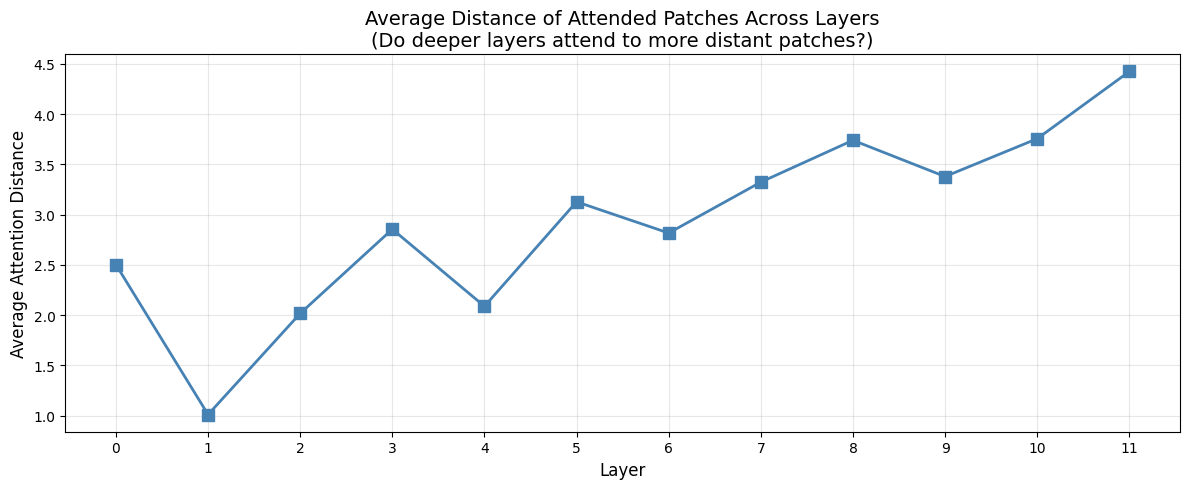


Average Attention Distance by Layer:
Layer 0: 2.5016
Layer 1: 1.0093
Layer 2: 2.0159
Layer 3: 2.8542
Layer 4: 2.0869
Layer 5: 3.1270
Layer 6: 2.8160
Layer 7: 3.3229
Layer 8: 3.7392
Layer 9: 3.3783
Layer 10: 3.7549
Layer 11: 4.4238


In [9]:
def compute_attention_distance(attention_weights):
    """
    Compute average distance of attended patches from CLS token.
    This tells us if layers attend to nearby vs far away patches.
    """
    patch_size = model.config.patch_size
    num_patches = model.config.image_size // patch_size

    # Create position grid
    positions = []
    for i in range(num_patches):
        for j in range(num_patches):
            positions.append([i, j])
    positions = torch.tensor(positions, dtype=torch.float32)

    # Center position (for CLS token conceptually)
    center = torch.tensor([num_patches / 2, num_patches / 2])

    # Compute distance from center for each patch
    distances = torch.sqrt(((positions - center) ** 2).sum(dim=1))

    avg_distances = []
    for layer_idx, attn in enumerate(attention_weights):
        # Average across batch and heads
        attn_avg = attn[0].mean(dim=0)

        # Get CLS attention to patches
        cls_attn = attn_avg[0, 1:]

        # Weighted average distance
        avg_dist = (cls_attn.cpu() * distances).sum().item()
        avg_distances.append(avg_dist)

    return avg_distances

avg_distances = compute_attention_distance(attention_weights)

plt.figure(figsize=(12, 5))
plt.plot(range(len(avg_distances)), avg_distances, 's-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Average Attention Distance', fontsize=12)
plt.title('Average Distance of Attended Patches Across Layers\n(Do deeper layers attend to more distant patches?)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(len(avg_distances)))
plt.tight_layout()
plt.show()

print("\nAverage Attention Distance by Layer:")
for i, dist in enumerate(avg_distances):
    print(f"Layer {i}: {dist:.4f}")

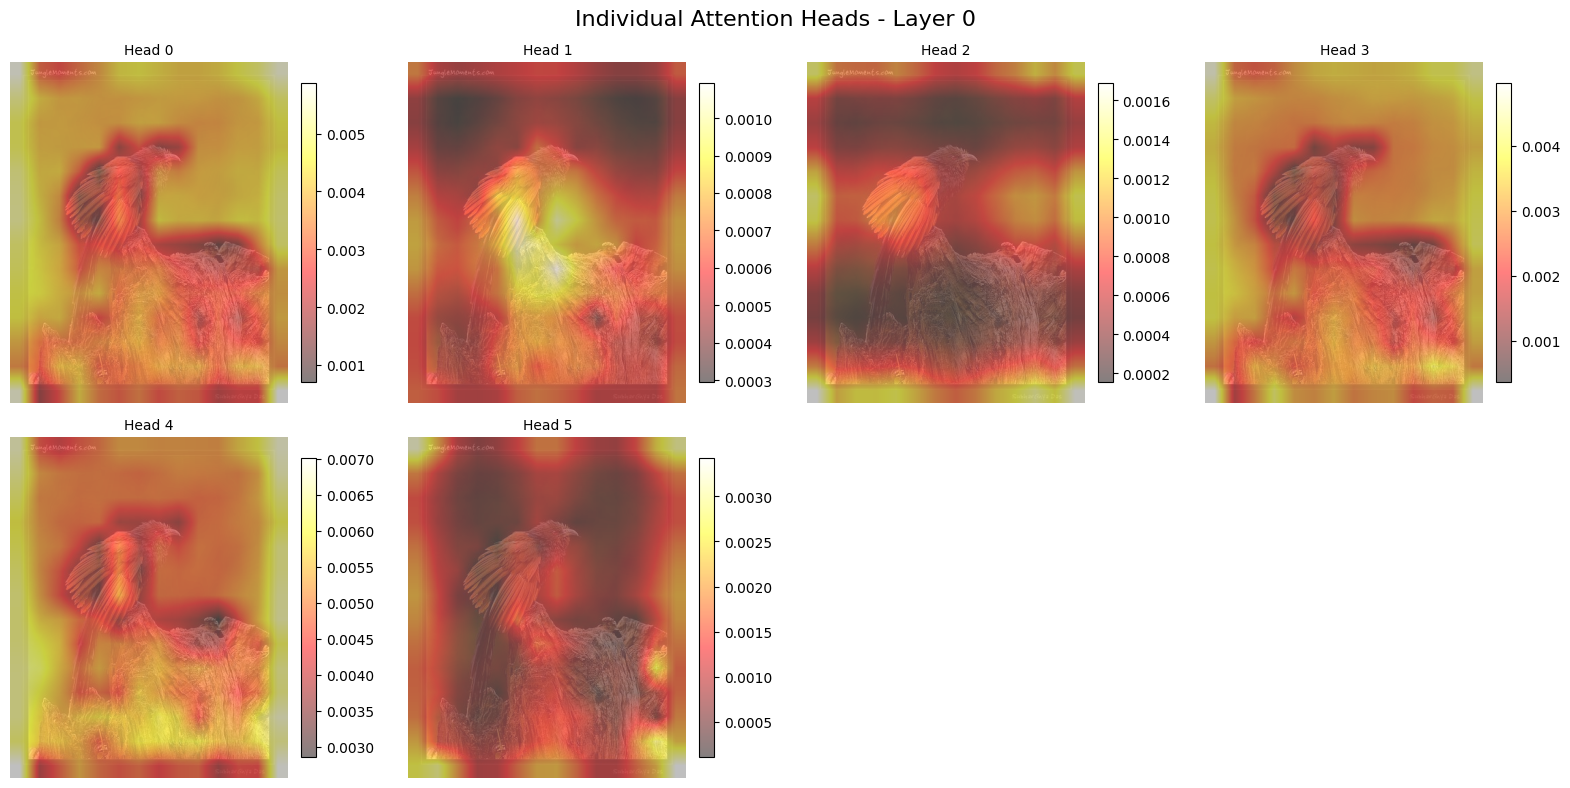

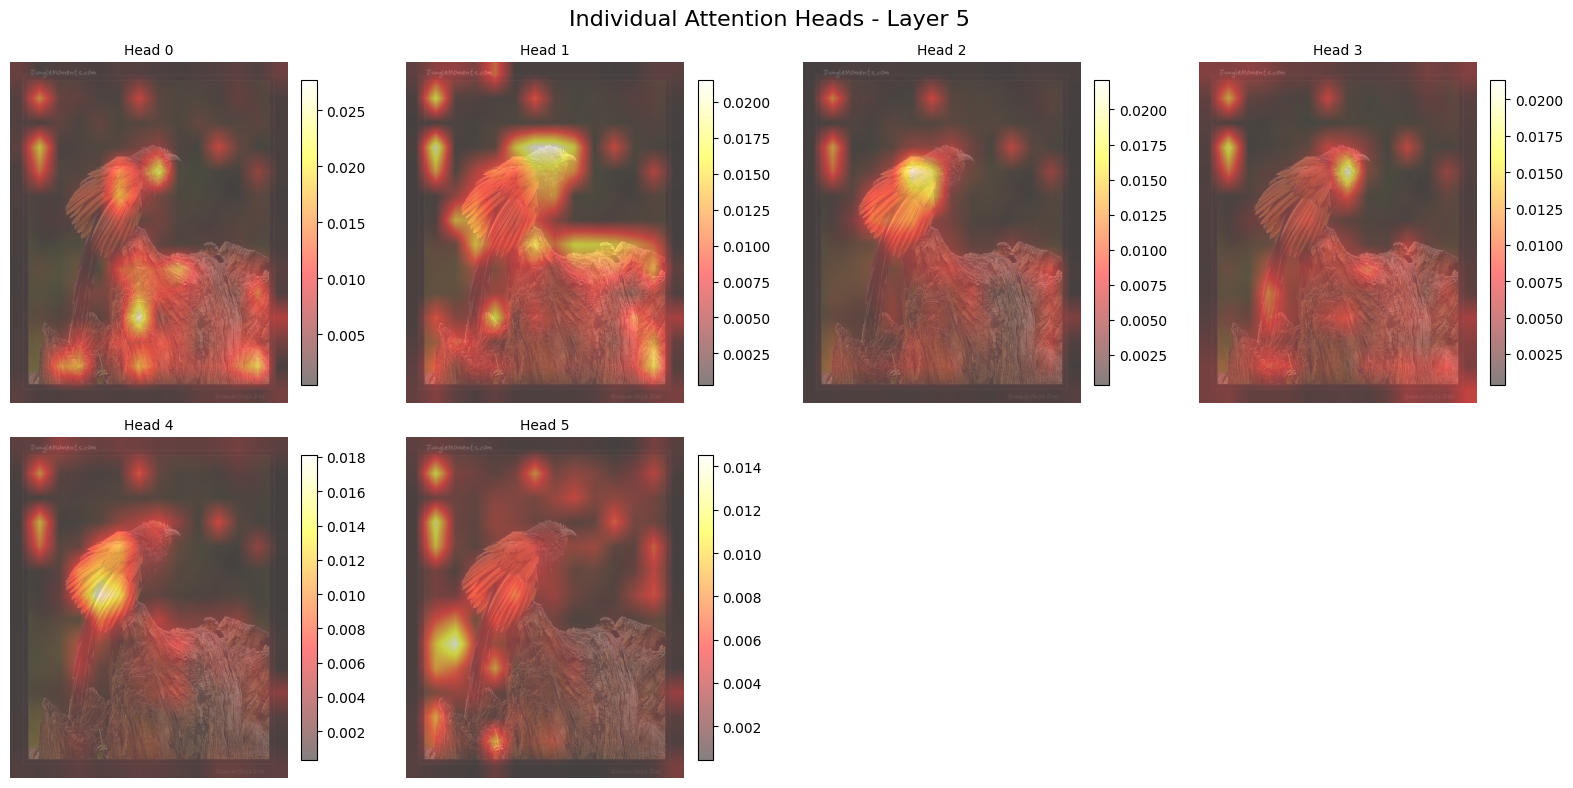

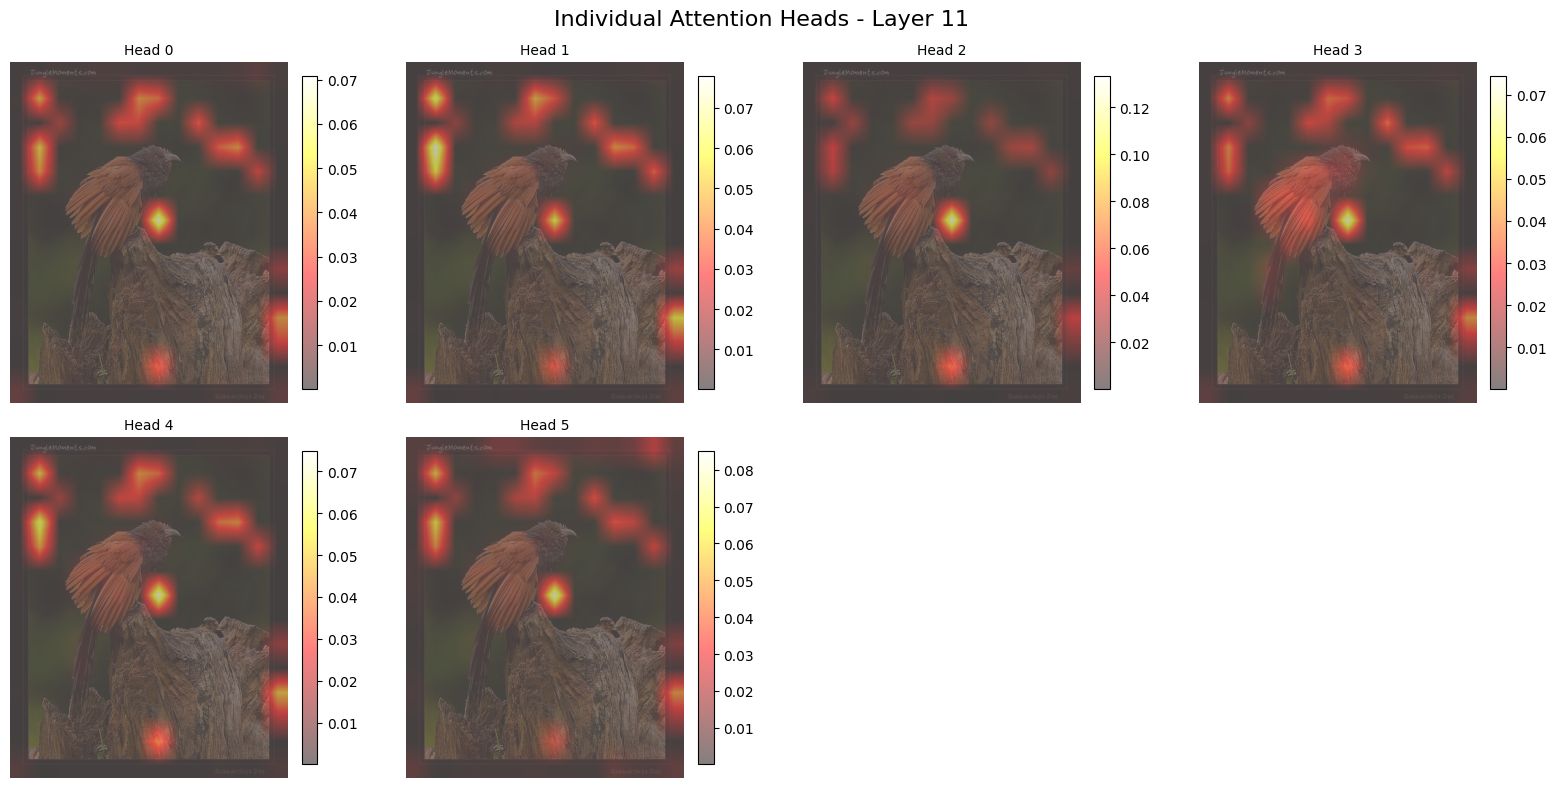

In [10]:
def analyze_attention_head_diversity(attention_weights, layer_idx=0):
    """
    Visualize individual attention heads for a specific layer
    to see if different heads focus on different patterns.
    """
    attn = attention_weights[layer_idx][0]  # (num_heads, num_patches+1, num_patches+1)
    num_heads = attn.shape[0]

    patch_size = model.config.patch_size
    num_patches = model.config.image_size // patch_size

    num_cols = 4
    num_rows = (num_heads + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    axes = axes.flatten()

    for head_idx in range(num_heads):
        # Get CLS attention for this head
        cls_attn = attn[head_idx, 0, 1:]
        cls_attn_2d = cls_attn.reshape(num_patches, num_patches).cpu().numpy()

        ax = axes[head_idx]
        ax.imshow(image, alpha=0.5)
        im = ax.imshow(cls_attn_2d, cmap='hot', alpha=0.5,
                      extent=[0, image.size[0], image.size[1], 0],
                      interpolation='bilinear')
        ax.set_title(f'Head {head_idx}', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide extra subplots
    for idx in range(num_heads, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Individual Attention Heads - Layer {layer_idx}', fontsize=16)
    plt.tight_layout()
    return fig

# Visualize heads for early, middle, and late layers
for layer_idx in [0, 5, 11]:
    fig = analyze_attention_head_diversity(attention_weights, layer_idx)
    plt.show()

In [11]:
def analyze_multiple_images(num_images=10):
    """
    Analyze attention patterns across multiple images to find general trends.
    """
    all_entropies = []
    all_distances = []

    print(f"Analyzing {num_images} images...")
    for idx in range(min(num_images, len(ds))):
        try:
            image = ds[idx]['image']
            if image.mode != 'RGB':
                image = image.convert('RGB')

            inputs = processor(images=image, return_tensors="pt")
            attention_weights, outputs = get_attention_weights(model, inputs.pixel_values)

            entropies = compute_attention_entropy(attention_weights)
            distances = compute_attention_distance(attention_weights)

            all_entropies.append(entropies)
            all_distances.append(distances)

            if (idx + 1) % 10 == 0:
                print(f"Processed {idx + 1}/{num_images} images")
        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            continue

    # Average across images
    avg_entropies = np.mean(all_entropies, axis=0)
    avg_distances = np.mean(all_distances, axis=0)
    std_entropies = np.std(all_entropies, axis=0)
    std_distances = np.std(all_distances, axis=0)

    return avg_entropies, std_entropies, avg_distances, std_distances

avg_entropies, std_entropies, avg_distances, std_distances = analyze_multiple_images(num_images=50)


Analyzing 50 images...
Registering hook on layer 0: ViTSelfAttention
Registering hook on layer 1: ViTSelfAttention
Registering hook on layer 2: ViTSelfAttention
Registering hook on layer 3: ViTSelfAttention
Registering hook on layer 4: ViTSelfAttention
Registering hook on layer 5: ViTSelfAttention
Registering hook on layer 6: ViTSelfAttention
Registering hook on layer 7: ViTSelfAttention
Registering hook on layer 8: ViTSelfAttention
Registering hook on layer 9: ViTSelfAttention
Registering hook on layer 10: ViTSelfAttention
Registering hook on layer 11: ViTSelfAttention

Starting forward pass...
Hook triggered on ViTSelfAttention
Output type: <class 'tuple'>
Tuple length: 2
  Item 0: Tensor with shape torch.Size([1, 197, 384])
  Item 1: Tensor with shape torch.Size([1, 6, 197, 197])
--------------------------------------------------
Hook triggered on ViTSelfAttention
Output type: <class 'tuple'>
Tuple length: 2
  Item 0: Tensor with shape torch.Size([1, 197, 384])
  Item 1: Tensor with

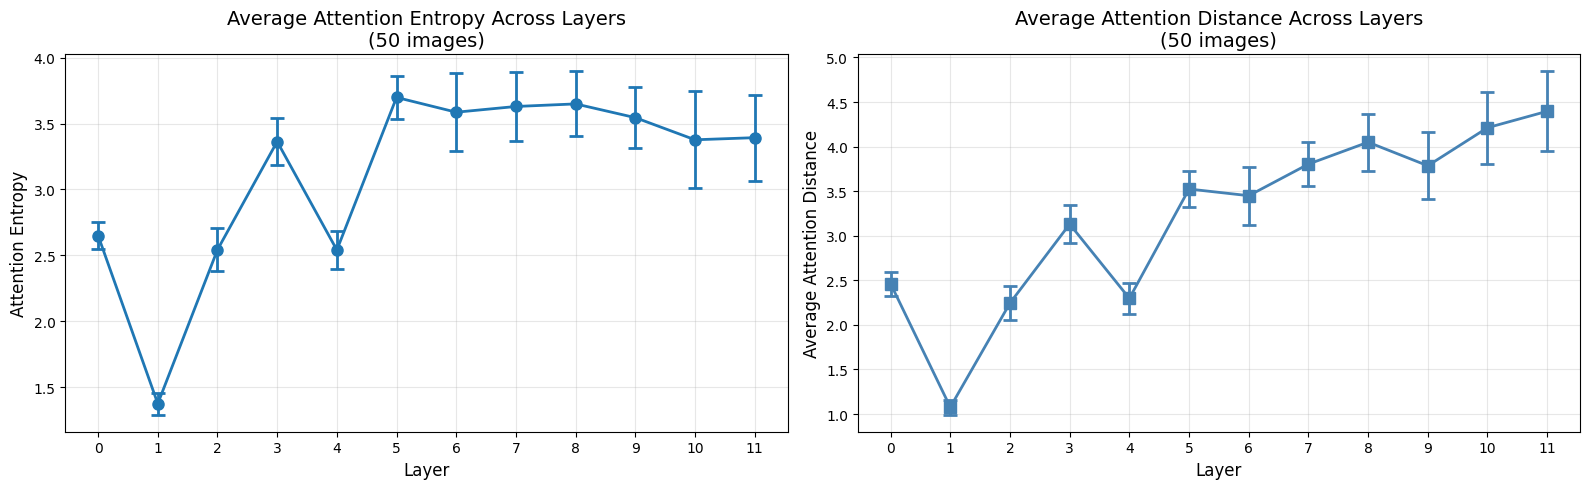

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

layers = range(len(avg_entropies))

# Plot 1: Average Entropy with error bars
ax1.errorbar(layers, avg_entropies, yerr=std_entropies,
             fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2)
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Attention Entropy', fontsize=12)
ax1.set_title('Average Attention Entropy Across Layers\n(50 images)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(layers)

# Plot 2: Average Distance with error bars
ax2.errorbar(layers, avg_distances, yerr=std_distances,
             fmt='s-', linewidth=2, markersize=8, capsize=5, capthick=2, color='steelblue')
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Average Attention Distance', fontsize=12)
ax2.set_title('Average Attention Distance Across Layers\n(50 images)', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(layers)

plt.tight_layout()
plt.show()

In [13]:
print("=" * 70)
print("SUMMARY OF FINDINGS")
print("=" * 70)

print("\n1. ATTENTION ENTROPY (Focus vs Dispersion):")
print(f"   Early layers (0-3) avg entropy: {np.mean(avg_entropies[:4]):.4f}")
print(f"   Middle layers (4-7) avg entropy: {np.mean(avg_entropies[4:8]):.4f}")
print(f"   Late layers (8-11) avg entropy: {np.mean(avg_entropies[8:]):.4f}")

print("\n2. ATTENTION DISTANCE:")
print(f"   Early layers (0-3) avg distance: {np.mean(avg_distances[:4]):.4f}")
print(f"   Middle layers (4-7) avg distance: {np.mean(avg_distances[4:8]):.4f}")
print(f"   Late layers (8-11) avg distance: {np.mean(avg_distances[8:]):.4f}")

print("\n3. KEY OBSERVATIONS:")
if avg_entropies[0] < avg_entropies[-1]:
    print("   ✓ Entropy increases from early to late layers → attention becomes more dispersed")
else:
    print("   ✓ Entropy decreases from early to late layers → attention becomes more focused")

if avg_distances[0] < avg_distances[-1]:
    print("   ✓ Distance increases from early to late layers → later layers attend to broader context")
else:
    print("   ✓ Distance decreases from early to late layers → later layers attend to more local features")

print("\n4. LAYER-SPECIFIC PATTERNS:")
most_focused_layer = np.argmin(avg_entropies)
most_dispersed_layer = np.argmax(avg_entropies)
print(f"   Most focused attention: Layer {most_focused_layer} (entropy: {avg_entropies[most_focused_layer]:.4f})")
print(f"   Most dispersed attention: Layer {most_dispersed_layer} (entropy: {avg_entropies[most_dispersed_layer]:.4f})")

print("\n" + "=" * 70)

SUMMARY OF FINDINGS

1. ATTENTION ENTROPY (Focus vs Dispersion):
   Early layers (0-3) avg entropy: 2.4828
   Middle layers (4-7) avg entropy: 3.3640
   Late layers (8-11) avg entropy: 3.4913

2. ATTENTION DISTANCE:
   Early layers (0-3) avg distance: 2.2285
   Middle layers (4-7) avg distance: 3.2686
   Late layers (8-11) avg distance: 4.1105

3. KEY OBSERVATIONS:
   ✓ Entropy increases from early to late layers → attention becomes more dispersed
   ✓ Distance increases from early to late layers → later layers attend to broader context

4. LAYER-SPECIFIC PATTERNS:
   Most focused attention: Layer 1 (entropy: 1.3745)
   Most dispersed attention: Layer 5 (entropy: 3.6988)



Registering hook on layer 0: ViTSelfAttention
Registering hook on layer 1: ViTSelfAttention
Registering hook on layer 2: ViTSelfAttention
Registering hook on layer 3: ViTSelfAttention
Registering hook on layer 4: ViTSelfAttention
Registering hook on layer 5: ViTSelfAttention
Registering hook on layer 6: ViTSelfAttention
Registering hook on layer 7: ViTSelfAttention
Registering hook on layer 8: ViTSelfAttention
Registering hook on layer 9: ViTSelfAttention
Registering hook on layer 10: ViTSelfAttention
Registering hook on layer 11: ViTSelfAttention

Starting forward pass...
Hook triggered on ViTSelfAttention
Output type: <class 'tuple'>
Tuple length: 2
  Item 0: Tensor with shape torch.Size([1, 197, 384])
  Item 1: Tensor with shape torch.Size([1, 6, 197, 197])
--------------------------------------------------
Hook triggered on ViTSelfAttention
Output type: <class 'tuple'>
Tuple length: 2
  Item 0: Tensor with shape torch.Size([1, 197, 384])
  Item 1: Tensor with shape torch.Size([1, 6

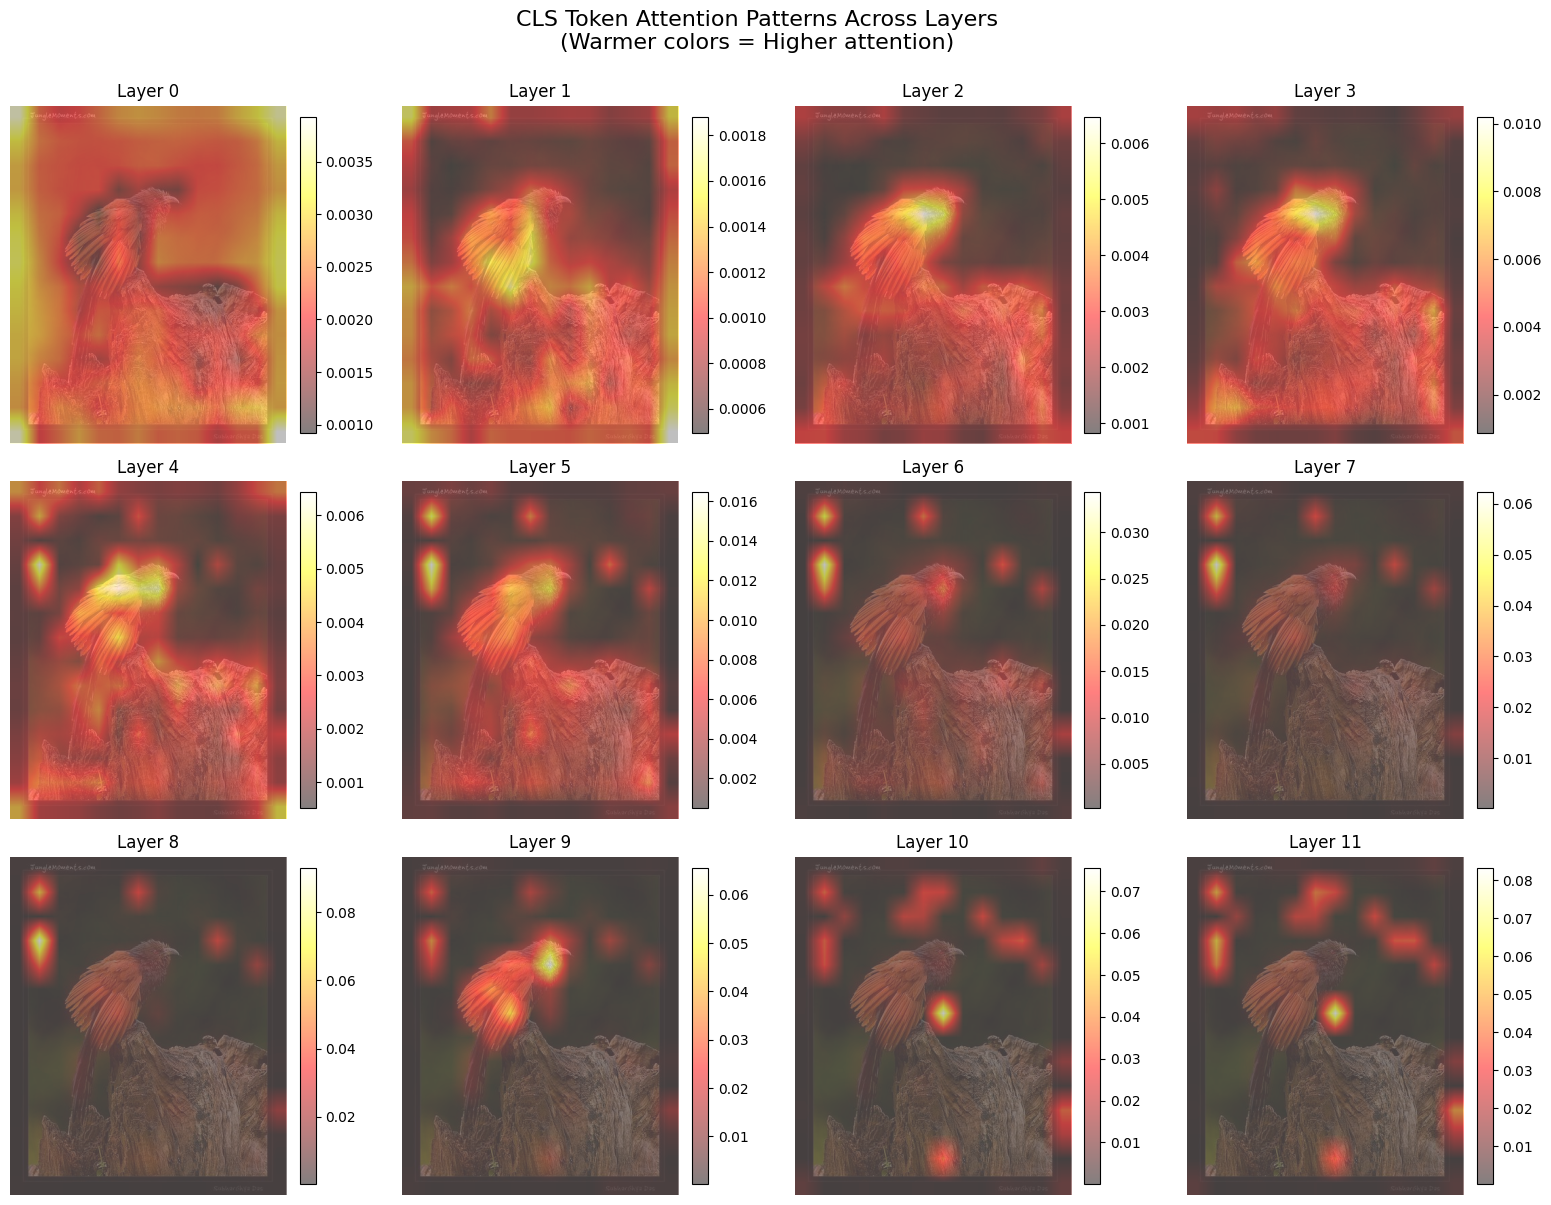

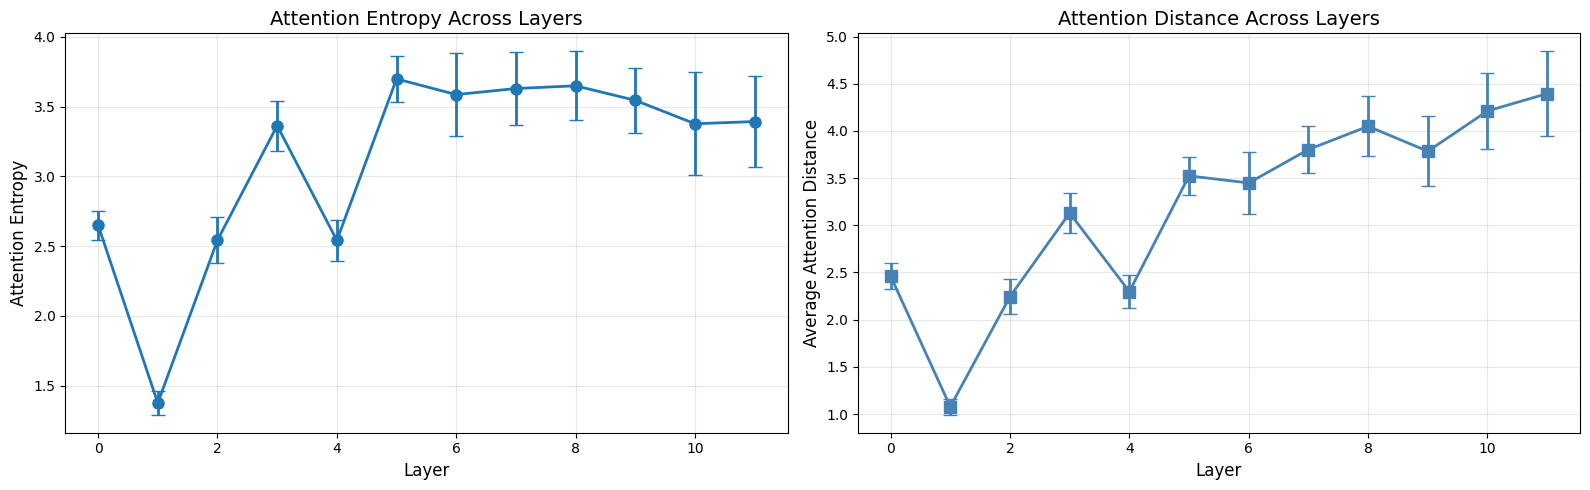

In [14]:
save_visualizations = True

if save_visualizations:
    # Regenerate the CLS attention grid for saving
    test_idx = 0
    image = ds[test_idx]['image']
    if image.mode != 'RGB':
        image = image.convert('RGB')

    inputs = processor(images=image, return_tensors="pt")
    attention_weights, outputs = get_attention_weights(model, inputs.pixel_values)

    fig = visualize_cls_attention_grid(attention_weights, image)
    plt.savefig('attention_patterns_across_layers.png', dpi=300, bbox_inches='tight')
    print("Saved: attention_patterns_across_layers.png")

    # Save aggregate results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    layers = range(len(avg_entropies))

    ax1.errorbar(layers, avg_entropies, yerr=std_entropies,
                 fmt='o-', linewidth=2, markersize=8, capsize=5)
    ax1.set_xlabel('Layer', fontsize=12)
    ax1.set_ylabel('Attention Entropy', fontsize=12)
    ax1.set_title('Attention Entropy Across Layers', fontsize=14)
    ax1.grid(True, alpha=0.3)

    ax2.errorbar(layers, avg_distances, yerr=std_distances,
                 fmt='s-', linewidth=2, markersize=8, capsize=5, color='steelblue')
    ax2.set_xlabel('Layer', fontsize=12)
    ax2.set_ylabel('Average Attention Distance', fontsize=12)
    ax2.set_title('Attention Distance Across Layers', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('attention_metrics_aggregate.png', dpi=300, bbox_inches='tight')
    print("Saved: attention_metrics_aggregate.png")